<a href="https://colab.research.google.com/github/RajatRasal/Gaussian-Process-Dynamical-Model/blob/main/experiments/Gaussian_Process_Latent_Variable_Model_for_Dynamical_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

# Gaussian Process Latent Variable Models

## Imports

In [1]:
!git clone https://github.com/RajatRasal/Gaussian-Process-Dynamical-Model.git

fatal: destination path 'Gaussian-Process-Dynamical-Model' already exists and is not an empty directory.


In [2]:
!pip install transforms3d

In [168]:
import sys
sys.path.append('Gaussian-Process-Dynamical-Model')

import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
from sklearn.decomposition import PCA
%pylab inline

from dataloader import amc_to_matrix

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
np_precision = np.float64

Populating the interactive namespace from numpy and matplotlib


## Load MNIST Data

In [169]:
!wget http://mocap.cs.cmu.edu/subjects/07/07_02.amc

--2022-04-16 17:54:36--  http://mocap.cs.cmu.edu/subjects/07/07_02.amc
Resolving mocap.cs.cmu.edu (mocap.cs.cmu.edu)... 128.2.220.105
Connecting to mocap.cs.cmu.edu (mocap.cs.cmu.edu)|128.2.220.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263117 (257K)
Saving to: ‘07_02.amc.8’

07_02.amc.8         100%[===================>] 256.95K   446KB/s    in 0.6s    

2022-04-16 17:54:37 (446 KB/s) - ‘07_02.amc.8’ saved [263117/263117]



In [183]:
x = amc_to_matrix('./07_02.amc')
small_x_train = np.array(x, dtype=np_precision)
small_x_train -= small_x_train.mean(axis=0)
N = small_x_train.shape[0]

In [184]:
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

## Prepare trainable variables
We'll be jointly training 3 model parameters as well as the latent inputs.

In [192]:
# Create some trainable model parameters. We will constrain them to be strictly
# positive when constructing the kernel and the GP.
unconstrained_amplitude = tf.Variable(np_precision(1.), name='amplitude')
unconstrained_length_scale = tf.Variable(np_precision(1.), name='length_scale')
unconstrained_slope_variance = tf.Variable(np_precision(1.), name='slope_variance')
unconstrained_observation_noise_var = tf.Variable(np_precision(1.), name='observation_noise_variance')

# We need to flatten the images and, somewhat unintuitively, transpose from
# shape [100, 784] to [784, 100]. This is because the 784 pixels will be
# treated as *independent* conditioned on the latent inputs, meaning we really
# have a batch of 784 GP's with 100 index_points.
observations_ = small_x_train.reshape(N, -1).transpose()

# Create a collection of N 2-dimensional index points that will represent our
# latent embeddings of the data. (Lawrence, 2004) prescribes initializing these
# with PCA, but a random initialization actually gives not-too-bad results, so
# we use this for simplicity. For a fun exercise, try doing the
# PCA-initialization yourself!
latent_dims = 3
latent_init = 'pca'
if latent_init == 'random':
    init_ = np.random.normal(size=(N, latent_dims)) \
        .astype(dtype=np_precision)
elif latent_init == 'pca':
    init_ = PCA(n_components=latent_dims) \
        .fit_transform(small_x_train) \
        .astype(dtype=np_precision)
latent_index_points = tf.Variable(init_, name='latent_index_points')

## Construct model and training ops

In [193]:
EPS = np.finfo(np_precision).eps

def contrain_positive(unconstrained_var):
    return tf.math.softplus(EPS + unconstrained_var)

def create_kernel(
    unconstrained_amplitude,
    unconstrained_length_scale,
    unconstrained_slope_variance,
):
    amplitude = contrain_positive(unconstrained_amplitude)
    length_scale = contrain_positive(unconstrained_length_scale)
    rbf_kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)
    linear_kernel = tfk.Linear(slope_variance=unconstrained_slope_variance)
    return rbf_kernel + linear_kernel

def build_gp(**gp_params):
    return tfd.GaussianProcessRegressionModel(**gp_params)

def loss_fn(
    obs,
    unconstrained_amplitude,
    unconstrained_length_scale,
    unconstrained_slope_variance,
    unconstrained_observation_noise_var,
    latent_index_points,
):
    observation_noise_variance = contrain_positive(unconstrained_observation_noise_var)
    kernel = create_kernel(
        unconstrained_amplitude,
        unconstrained_length_scale,
        unconstrained_slope_variance,
    )
    gp = build_gp(
        kernel=kernel,
        index_points=latent_index_points,
        observation_noise_variance=observation_noise_variance,
    )
    log_probs = gp.log_prob(obs, name='log_prob')
    return -tf.reduce_mean(log_probs)

LR = 0.1
optimizer = tf.optimizers.Adam(learning_rate=LR)

@tf.function(autograph=False, jit_compile=True)
def train_model():
    trainable_variables = [
        unconstrained_amplitude,
        unconstrained_length_scale,
        unconstrained_slope_variance,
        unconstrained_observation_noise_var,
        latent_index_points
    ]
    with tf.GradientTape() as tape:
        loss_value = loss_fn(observations_, *trainable_variables)
    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss_value

## Train and plot the resulting latent embeddings

In [194]:
# Initialize variables and train!
num_iters = 1000
log_interval = 100
lips = np.zeros((num_iters, N, latent_dims), np_precision)
for i in range(num_iters):
    loss = train_model()
    lips[i] = latent_index_points.numpy()
    if i % log_interval == 0 or i + 1 == num_iters:
        print("Loss at step %d: %f" % (i, loss))

Loss at step 0: 1211.220668
Loss at step 100: 425.018493
Loss at step 200: 359.909402
Loss at step 300: 336.744176
Loss at step 400: 314.328369
Loss at step 500: 305.878740
Loss at step 600: 301.894057
Loss at step 700: 301.482605
Loss at step 800: 292.623486
Loss at step 900: 290.855267
Loss at step 999: 290.027020


## Plot results

In [146]:
def plotting_latent_2d(before, after):
    plt.figure(figsize=(7, 7))
    plt.title("Before training")
    plt.grid(False)
    plt.scatter(
        x=before[:, 0],
        y=before[:, 1],
        color='green',
        s=50
    )
    plt.show()

    plt.figure(figsize=(7, 7))
    plt.title("After training")
    plt.grid(False)
    plt.scatter(
        x=after[:, 0],
        y=after[:, 1],
        color='blue',
        s=50
    )
    plt.show()

def plotting_latent_3d(before, after):
    plt.figure(figsize=(7, 7))
    ax = plt.axes(projection='3d')
    ax.set_title("Before training")
    ax.scatter3D(
        before[:, 0],
        before[:, 1],
        before[:, 2],
        color='green',
        # s=50
    )
    plt.show()
    
    plt.figure(figsize=(7, 7))
    ax = plt.axes(projection='3d')
    ax.set_title("After training")
    ax.scatter3D(
        after[:, 0],
        after[:, 1],
        after[:, 2],
        color='blue',
        # s=50
    )
    plt.show()

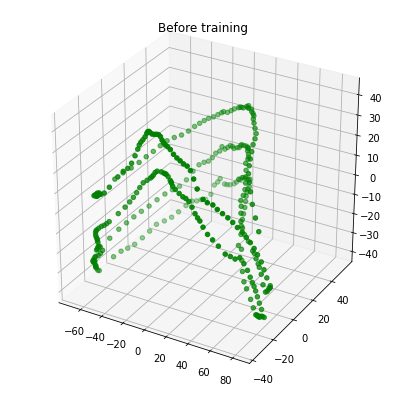

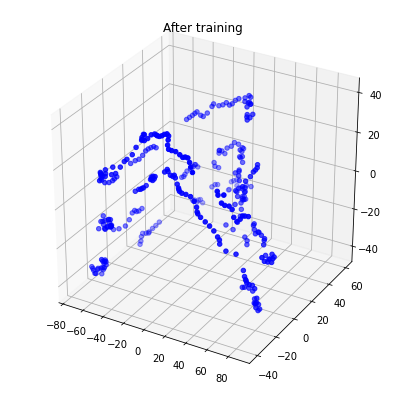

In [147]:
# Plot the latent locations before and after training
if latent_dims == 2:
    plotting_latent_2d(init_, latent_index_points.numpy())
elif latent_dims == 3:
    plotting_latent_3d(init_, latent_index_points.numpy())
else:
    pass

In [195]:
# Joint Training

In [ ]:
def build_gp_joint_model(gp):
    return tfd.JointDistributionNamed({
        'amplitude': tfd.LogNormal(loc=0., scale=np_precision(1.)),
        'length_scale': tfd.LogNormal(loc=0., scale=np_precision(1.)),
        'slope_variance': tfd.LogNormal(loc=0., scale=np_precision(1.)),
        'observation_noise_variance': tfd.LogNormal(loc=0., scale=np_precision(1.)),
        'latent': tfd.Normal(loc=0., scale=np.eye())  # TODO: Check this
        'observations': gp,
    })

def joint_log_prob(gp, obs, amplitude, length_scale, slope_variance, observation_noise_variance):
    gp_joint_model = build_gp_joint_model(gp)
    return gp_joint_model.log_prob({
        'amplitude': amplitude,
        'length_scale': length_scale,
        'slope_variance': slope_variance,
        'observation_noise_variance': observation_noise_variance,
        'observations': obs,
    })

@tf.function(autograph=False, jit_compile=False)
def train_model_joint():
    with tf.GradientTape() as tape:
        loss = -joint_log_prob(
            amplitude_var, length_scale_var,
            observation_noise_variance_var
        )
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss

## Construct predictive model and sampling ops

In [67]:
gprm = build_gp(
    kernel=kernel,
    index_points=latent_index_points,
    observation_index_points=latent_index_points,
    observations=observations_,
)

samples = gprm.sample()

# Plot the grid of samples at new points. We do a bit of tweaking of the samples
# first, squeezing off extra 1-shapes and normalizing the values.
samples_ = np.squeeze(samples.numpy())
samples_ = (
    (samples_ - samples_.min(-1, keepdims=True)) /
    (samples_.max(-1, keepdims=True) - samples_.min(-1, keepdims=True))
)
samples_ = samples_.reshape(sample_grid_points, sample_grid_points, 28, 28)
samples_ = samples_.transpose([0, 2, 1, 3])
samples_ = samples_.reshape(28 * sample_grid_points, 28 * sample_grid_points)
plt.figure(figsize=(7, 7))
ax = plt.subplot()
ax.grid(False)
ax.imshow(-samples_, interpolation='none', cmap='Greys')
plt.show()

InvalidArgumentError: ignored

In [123]:
sample_grid_points = 100
grid_ = np.linspace(-4, 4, sample_grid_points).astype(np_precision)
print(grid_.shape)
grid_ = np.stack(np.meshgrid(grid_, grid_), axis=-1)
grid_.shape

(100,)


(100, 100, 2)

In [124]:
# We'll draw samples at evenly spaced points on a 10x10 grid in the latent
# input space. 
# sample_grid_points = 100
# grid_ = np.linspace(-4, 4, sample_grid_points).astype(np_precision)
# Create a 10x10 grid of 2-vectors, for a total shape [10, 10, 2]
# grid_ = np.stack(np.meshgrid(grid_, grid_), axis=-1)

# This part's a bit subtle! What we defined above was a batch of 784 (=28x28)
# independent GP distributions over the input space. Each one corresponds to a
# single pixel of an MNIST image. Now what we'd like to do is draw 100 (=10x10)
# *independent* samples, each one separately conditioned on all the observations
# as well as the learned latent input locations above.
#
# The GP regression model below will define a batch of 784 independent
# posteriors. We'd like to get 100 independent samples each at a different
# latent index point. We could loop over the points in the grid, but that might
# be a bit slow. Instead, we can vectorize the computation by tacking on *even
# more* batch dimensions to our GaussianProcessRegressionModel distribution.
# In the below grid_ shape, we have concatentaed
#   1. batch shape: [sample_grid_points, sample_grid_points, 1]
#   2. number of examples: [1]
#   3. number of latent input dimensions: [2]
# The `1` in the batch shape will broadcast with 784. The final result will be
# samples of shape [10, 10, 784, 1]. The `1` comes from the "number of examples"
# and we can just `np.squeeze` it off.

# grid_ = grid_.reshape(sample_grid_points, sample_grid_points, 1, 1, 2)

# Create the GPRegressionModel instance which represents the posterior
# predictive at the grid of new points.
gprm = tfd.GaussianProcessRegressionModel(
    kernel=create_kernel(),
    # Shape [10, 10, 1, 1, 2]
    index_points=latent_index_points,
    # Shape [1000, 2]. 1000 2 dimensional vectors.
    observation_index_points=latent_index_points,
    # Shape [784, 1000]. A batch of 784 1000-dimensional observations.
    observations=observations_,
)

In [ ]:
num_results = 100
num_burnin_steps = 50

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target_log_prob,
        step_size=tf.cast(0.1, tf.float64)),
    bijector=[constrain_positive, constrain_positive, constrain_positive])

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=tf.cast(0.75, tf.float64))

initial_state = [tf.cast(x, tf.float64) for x in [1., 1., 1.]]

In [125]:
samples = gprm.sample()

In [126]:
samples.shape

TensorShape([62, 329])

## Draw samples conditioned on the data and latent embeddings
We sample at 100 points on a 2-d grid in the latent space.

## Conclusion
We've taken a brief tour of the Gaussian process latent variable model, and
shown how we can implement it in just a few lines of TF and TF Probability
code.